In [1]:
%pip install numpy matplotlib scapy[basic] tqdm

  Using cached https://files.pythonhosted.org/packages/62/20/4d43e141b5bc426ba38274933ef8e76e85c7adea2c321ecf9ebf7421cedf/numpy-1.18.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7e/07/4b361d6d0f4e08942575f83a11d33f36897e1aae4279046606dd1808778a/matplotlib-3.1.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/cd/80/5bb262050dd2f30f8819626b7c92339708fe2ed7bd5554c8193b4487b367/tqdm-4.42.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5d/bc/1e58593167fade7b544bfe9502a26dc860940a79ab306e651e7f13be68c2/pyparsing-2.4.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f8/a1/5742b56282449b1c0968197f63eae486eca2c35dcd334bab75ad524e0de1/kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached ht

In [1]:
import random
import numpy as np
from tqdm import tqdm
from scapy.all import PcapReader
from scapy.layers.dot11 import Dot11ProbeReq


def accumulate(file, *accumulators):
    with PcapReader(file) as reader, tqdm(unit='packets', desc=file) as pbar:
        for packet in reader:
            for accumulator in accumulators:
                accumulator(packet)
            pbar.update()
        return accumulators


class TimeSeriesAccumulator(list):
    TYPE = ('timestamp', np.float), ('mac', np.bytes_, 6)
    
    def __call__(self, packet):
        if packet.haslayer(Dot11ProbeReq):
            timestamp = packet.time
            mac = bytes.fromhex(packet.addr2.replace(':', ''))
            self.append((timestamp, mac))
            
    def as_numpy_array(self):
        return np.array(self, dtype=np.dtype([*self.TYPE]))


class RandomProbeSampler(list):
    PROBABILITY = 0.001
    
    def __call__(self, packet):
        if packet.haslayer(Dot11ProbeReq) and random.random() <= self.PROBABILITY:
            self.append(packet)

In [2]:
from captures import commutes

commute_time_series = dict()  # commute -> feature matrix
commute_samples = dict()  # commute -> list of probe request samples

for commute in commutes:
    features, samples = accumulate(commute.filename, TimeSeriesAccumulator(), RandomProbeSampler())
    commute_time_series[commute] = features.as_numpy_array()
    commute_samples[commute] = samples

capture-0-a4.pcap: 57279packets [01:02, 915.18packets/s] 
capture-1-a4.pcap: 67268packets [01:15, 886.63packets/s] 
capture-2-a4.pcap: 59223packets [01:05, 902.27packets/s] 
capture-5-a4.pcap: 67624packets [01:09, 974.52packets/s] 
capture-6-a4.pcap: 100160packets [01:34, 1063.79packets/s]
capture-7-a4.pcap: 82099packets [01:27, 936.63packets/s] 


In [42]:
%matplotlib inline

import matplotlib.pyplot as plt


def plot_line_chart(data, x_label=None, y_label=None, x_scale='linear', y_scale='linear'):
    plt.figure(figsize=(18, 6))
    legends = []
    for xs, ys, legend in data:
        plt.plot(xs, ys)
        legends.append(legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale(x_scale)
    plt.yscale(y_scale)
    plt.legend(legends)

In [25]:
import math


def duration(timestamps):
    return np.amax(timestamps) - np.amin(timestamps)


def frequency_count(timestamps, time_interval):
    number_of_intervals = math.ceil(duration(timestamps) / time_interval)
    counts = np.zeros(number_of_intervals)
    rel_timestamps = timestamps - np.amin(timestamps)
    for timestamp in rel_timestamps:
        counts[math.floor(timestamp / time_interval)] += 1
    time = np.arange(0, len(counts) * time_interval, time_interval)
    return time, counts

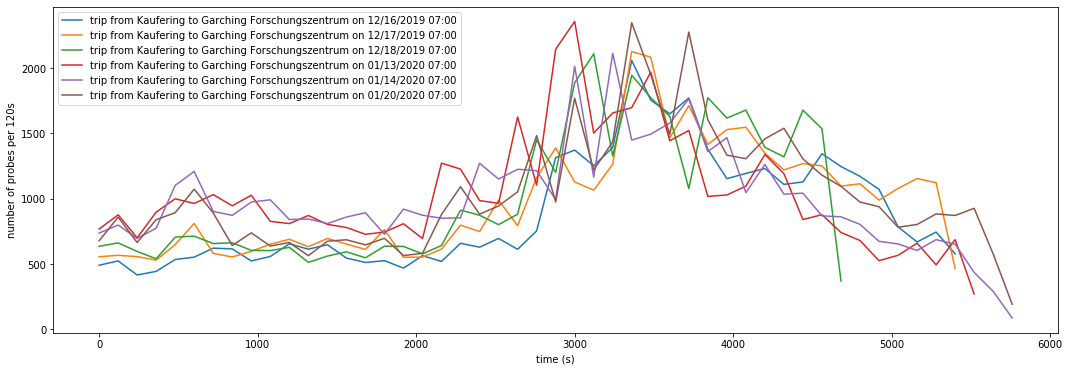

In [43]:
TIME_INTERVAL = 120

plots = []

for commute in commutes:
    legend = '{} on {:%m/%d/%Y %H:%M}'.format(commute.description, commute.start_date)
    timestamps = commute_time_series[commute][:]['timestamp']
    xs, ys = frequency_count(timestamps, TIME_INTERVAL)
    plots.append((xs, ys, legend))

plot_line_chart(plots, x_label='time (s)', y_label='number of probes per {}s'.format(TIME_INTERVAL))

# Observations
- The trip on 12/18/2019 (green line) ends early because of the battery running out.
- The change of number of packets per 100s across time is consistent in relative terms.
- The number of packets per 100s starts at about 500 in Kaufering, grows until Central Station until 2000 packets per 100s, 
  peaks multiple times around the city center, and decreases until the destination Garching Forschungszentrum.

In [59]:
from collections import defaultdict


def compute_inter_contact_times(probes):
    min_max_timestamps = defaultdict(tuple)  # mac -> min, max timestamp
    for probe in probes:
        current_min_max = min_max_timestamps[probe['mac']]
        min_timestamp = min([*current_min_max, probe['timestamp']])
        max_timestamp = max([*current_min_max, probe['timestamp']])
        min_max_timestamps[probe['mac']] = min_timestamp, max_timestamp
    return sorted(max_timestamp - min_timestamp for min_timestamp, max_timestamp in min_max_timestamps.values())

In [34]:
def compute_cdf(values):
    total = len(values)
    accumulator = 0
    ys, xs = [], []
    current_value = None
    for value in values:
        if current_value != value and current_value is not None:
            ys.append(accumulator)
            xs.append(current_value)
        current_value = value
        accumulator += 1 / total
    return xs, ys
    

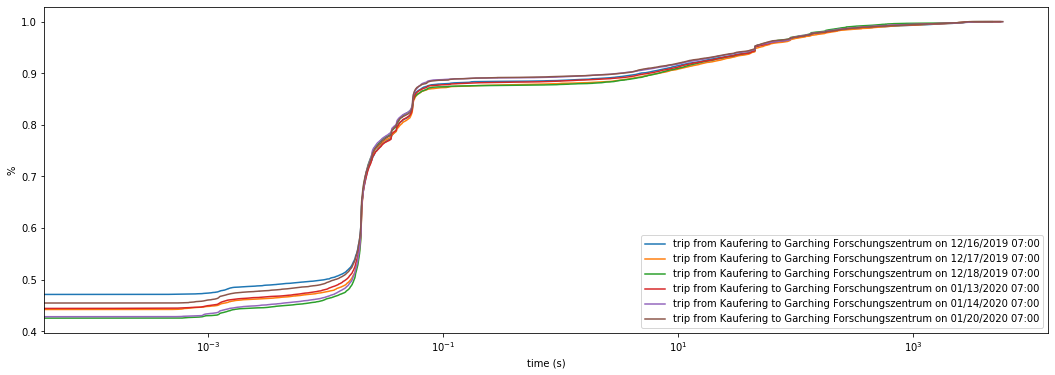

In [60]:
plots = []

for commute in commutes:
    legend = '{} on {:%m/%d/%Y %H:%M}'.format(commute.description, commute.start_date)
    inter_contact_times = compute_inter_contact_times(commute_time_series[commute])
    xs, ys = compute_cdf(inter_contact_times)
    plots.append((xs, ys, legend))

plot_line_chart(plots, x_label='time (s)', y_label='%', x_scale='log')

# Observations
- Almost 90% of MAC addresses are seen for less than 0.1 seconds.
 - Probably due to MAC address randomization
- The phone carried by the conductor of the measurement does not perform MAC address randomization. 